<a href="https://colab.research.google.com/github/klabuttt/Pemprosesan-Teks/blob/main/Clustering_CapCut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
pip install pandas scikit-learn matplotlib nltk gensim Sastrawi

**LOAD DATA**

---



In [40]:
import pandas as pd
import numpy as np
import re
import nltk
import warnings
import gensim
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
import matplotlib.pyplot as plt


df = pd.read_csv('dataUlasan.csv')
df.head()


,Rating,Komentar
0,1,parah pake text otomatis saja prabayar jgn di ...
1,3,knp aplikasinya hang trs pdhl baru aja di-upda...
2,5,saya senang
3,1,ya smua aja di premium capcut mo naik haji apa...
4,5,bagus tapi tolong kurangi iklan nya


In [41]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

**Preprocessing (cleaning, tokenizing, stopwords, stemming)**

---



In [42]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

stopword_factory = StopWordRemoverFactory()
stop_words = set(stopword_factory.get_stop_words())

stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

def preprocessing(text):
    text = clean_text(text)
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stop_words and len(w) > 2]
    tokens = [stemmer.stem(w) for w in tokens]
    return ' '.join(tokens)

df['clean_text'] = df['Komentar'].astype(str).apply(preprocessing)

In [43]:
display(df[['Komentar', 'clean_text']].head())

,Komentar,clean_text
0,parah pake text otomatis saja prabayar jgn di ...,parah pake text otomatis prabayar jgn donlod a...
1,knp aplikasinya hang trs pdhl baru aja di-upda...,knp aplikasi hang trs pdhl baru aja update apl...
2,saya senang,senang
3,ya smua aja di premium capcut mo naik haji apa...,smua aja premium capcut naik haji apa gmn dah
4,bagus tapi tolong kurangi iklan nya,bagus kurang iklan nya


**Feature Extraction (TF-IDF/COUNT)**

---



In [44]:
tfidf = TfidfVectorizer(
    stop_words=list(stop_words),
    max_df=0.9,
    min_df=5,
    ngram_range=(1,2)
)

X_tfidf = tfidf.fit_transform(df['clean_text'].astype(str))

In [45]:
print("Jumlah dokumen      :", X_tfidf.shape[0])
print("Jumlah fitur (kata) :", X_tfidf.shape[1])

Jumlah dokumen      : 1996
Jumlah fitur (kata) : 669


**Menentukan K untuk K-Means — Elbow Method + Silhouette**

---



In [46]:
inertia = []
K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_tfidf)
    inertia.append(km.inertia_)
for k, wcss in zip(K_range, inertia):
    print(f"K = {k}, WCSS = {wcss:.4f}")

K = 2, WCSS = 1738.6895
K = 3, WCSS = 1700.6590
K = 4, WCSS = 1670.0322
K = 5, WCSS = 1652.9843
K = 6, WCSS = 1637.0550
K = 7, WCSS = 1643.4330
K = 8, WCSS = 1606.5378
K = 9, WCSS = 1592.5654
K = 10, WCSS = 1586.0687


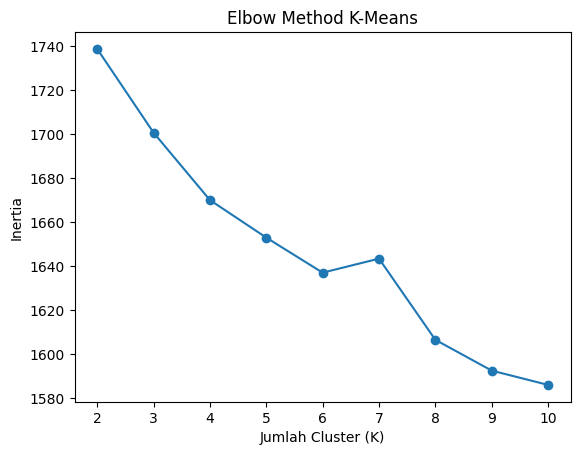

In [47]:
plt.plot(K_range, inertia, marker='o')
plt.xlabel("Jumlah Cluster (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method K-Means")
plt.show()

**K-Means Clustering**

---


In [48]:
k_optimal = 5

kmeans = KMeans(
    n_clusters=k_optimal,
    random_state=42,
    n_init=10
)

df['cluster_kmeans'] = kmeans.fit_predict(X_tfidf)

**Silhouette Score**

---



In [49]:
silhouette_avg = silhouette_score(X_tfidf, kmeans.labels_)
print(f"Average Silhouette Score (K={k_optimal}) = {silhouette_avg:.4f}")

Average Silhouette Score (K=5) = 0.0605


In [52]:
for k in range(2, 9):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_k = km.fit_predict(X_tfidf)
    score = silhouette_score(X_tfidf, labels_k)
    print(f"K = {k}, Silhouette = {score:.4f}")


K = 2, Silhouette = 0.0490
K = 3, Silhouette = 0.0520
K = 4, Silhouette = 0.0572
K = 5, Silhouette = 0.0605
K = 6, Silhouette = 0.0583
K = 7, Silhouette = 0.0557
K = 8, Silhouette = 0.0648


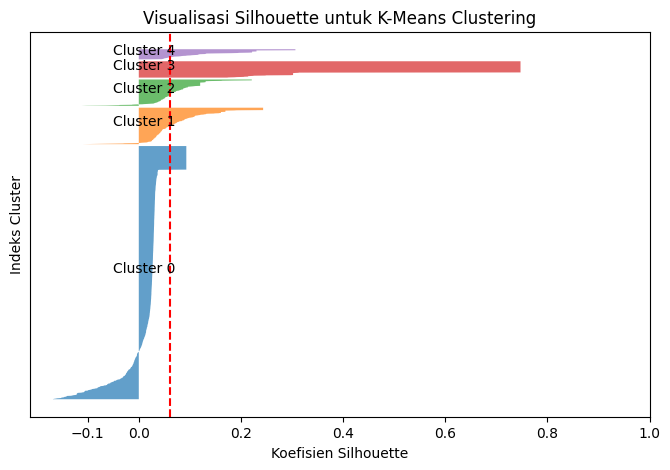

In [51]:
sample_silhouette_values = silhouette_samples(X_tfidf, kmeans.labels_)
y_lower = 10
plt.figure(figsize=(8, 5))

for i in range(k_optimal):
    ith_cluster_silhouette_values = sample_silhouette_values[kmeans.labels_ == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    plt.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        alpha=0.7
    )

    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, f"Cluster {i}")
    y_lower = y_upper + 10

plt.title("Visualisasi Silhouette untuk K-Means Clustering")
plt.xlabel("Koefisien Silhouette")
plt.ylabel("Indeks Cluster")
plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.yticks([]) # Clear the yaxis labels / ticks
plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.show()

**Visualisasi PCA Scatter Plot**

---



In [53]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_tfidf.toarray())

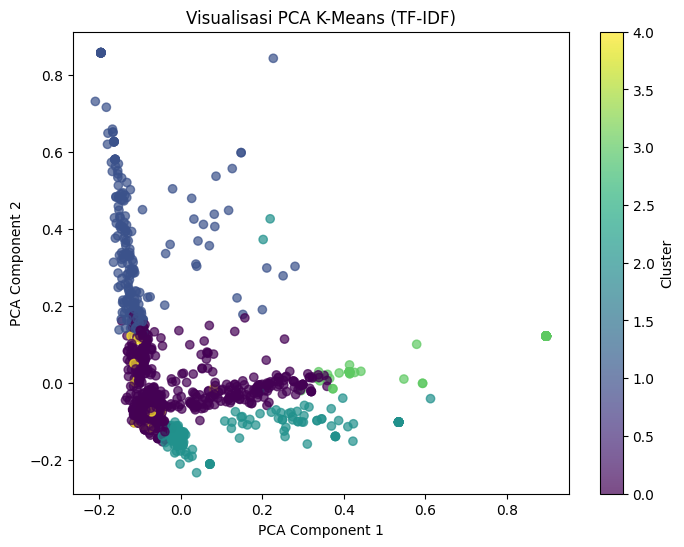

In [54]:
plt.figure(figsize=(8, 6))

scatter = plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=kmeans.labels_,
    alpha=0.7
)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Visualisasi PCA K-Means (TF-IDF)")
plt.colorbar(scatter, label="Cluster")

plt.show()

**Interpretasi Cluster (Top Keywords)**

---



In [57]:
terms = tfidf.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

for i in range(k_optimal):
    top_terms = [terms[ind] for ind in order_centroids[i, :10]]
    print(f"Cluster {i}: {top_terms}")

Cluster 0: ['aplikasi', 'bayar', 'capcut', 'nya', 'bagus', 'apk', 'suka', 'aku', 'makin', 'pro']
Cluster 1: ['iklan', 'banyak iklan', 'banyak', 'nya', 'iklan nya', 'terlalu', 'terlalu banyak', 'makin', 'bagus', 'sekarang']
Cluster 2: ['sangat', 'sangat bagus', 'bagus', 'aplikasi sangat', 'bantu', 'sangat bantu', 'aplikasi', 'edit', 'sangat suka', 'nya sangat']
Cluster 3: ['bagus', 'bagus banget', 'banget', 'aplikasi', 'kok', 'bagus bagus', 'ngedit', 'capcut', 'bagus aja', 'sih']
Cluster 4: ['kikir', 'apk kikir', 'aplikasi kikir', 'apk', 'aplikasi', 'makin', 'makin kikir', 'pro', 'jir', 'kebelet']


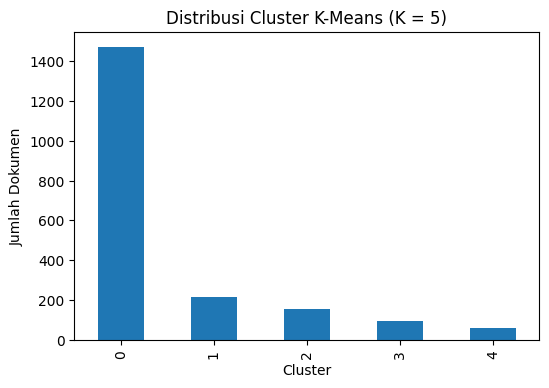

In [56]:
cluster_counts = df['cluster_kmeans'].value_counts().sort_index()
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar')
plt.xlabel("Cluster")
plt.ylabel("Jumlah Dokumen")
plt.title("Distribusi Cluster K-Means (K = 5)")
plt.show()

**Topic Modeling (LDA)**

---



In [58]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [61]:
count_vect = CountVectorizer(
    stop_words=list(stop_words), # Corrected from 'indonesian'
    max_df=0.9,
    min_df=5
)

X_count = count_vect.fit_transform(df['clean_text'])

In [62]:
n_topics = 4
lda = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,
    learning_method='batch'
)

lda.fit(X_count)

LatentDirichletAllocation(n_components=4, random_state=42)

In [63]:
words = count_vect.get_feature_names_out()

for topic_idx, topic in enumerate(lda.components_):
    top_words = [words[i] for i in topic.argsort()[:-11:-1]]
    print(f"Topic {topic_idx}: {top_words}")


Topic 0: ['iklan', 'banyak', 'mau', 'ekspor', 'udah', 'jelek', 'bayar', 'terus', 'dulu', 'malah']
Topic 1: ['bagus', 'sangat', 'aplikasi', 'capcut', 'nya', 'aku', 'edit', 'suka', 'buat', 'bintang']
Topic 2: ['makin', 'banyak', 'nya', 'iklan', 'banget', 'bagus', 'aplikasi', 'apk', 'kikir', 'lama']
Topic 3: ['bayar', 'semua', 'apa', 'capcut', 'pro', 'aplikasi', 'fitur', 'aja', 'apk', 'gak']


In [64]:
topic_distribution = lda.transform(X_count)
df['topic_lda'] = topic_distribution.argmax(axis=1)


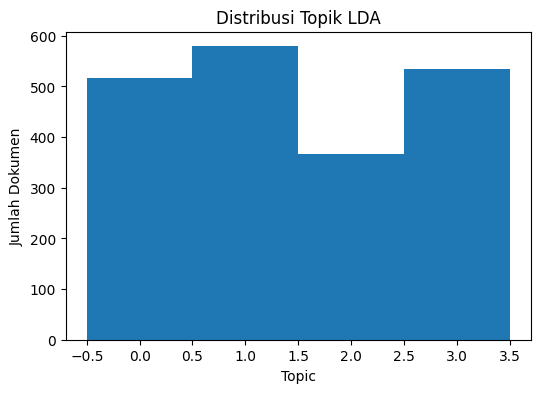

In [65]:
topic_dist = lda.transform(X_count)
dominant_topics = topic_dist.argmax(axis=1)

plt.figure(figsize=(6,4))
plt.hist(dominant_topics, bins=range(lda.n_components+1), align='left')
plt.xlabel("Topic")
plt.ylabel("Jumlah Dokumen")
plt.title("Distribusi Topik LDA")
plt.show()

In [76]:
#Menghilangkan Warning
warnings.filterwarnings("ignore", message="datetime.datetime.utcnow")

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [77]:
texts = [text.split() for text in df['clean_text']]

dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

topics = [
    [words[i] for i in topic.argsort()[:-11:-1]]
    for topic in lda.components_
]

coherence_model = CoherenceModel(
    topics=topics,
    texts=texts,
    dictionary=dictionary,
    coherence='c_v'
)

print("Coherence Score:", coherence_model.get_coherence())


Coherence Score: 0.627714888332779


**KESIMPULAN**

---



Berdasarkan hasil K-Means clustering terhadap data komentar, diperoleh jumlah cluster optimal sebanyak 5 cluster yang ditentukan menggunakan Elbow Method dan divalidasi dengan Silhouette Score. Metode ini berhasil mengelompokkan komentar berdasarkan kemiripan teks, di mana setiap komentar hanya masuk ke satu cluster. Meskipun nilai Silhouette relatif rendah, hal tersebut merupakan karakteristik umum pada data teks berbasis TF-IDF dan tidak menunjukkan kegagalan model. Visualisasi PCA serta distribusi cluster menunjukkan bahwa data tersebar secara relatif merata, sehingga hasil clustering dapat digunakan untuk keperluan segmentasi data.

Topic modeling menggunakan Latent Dirichlet Allocation (LDA) berhasil mengidentifikasi topik-topik utama yang terkandung dalam data komentar, di mana setiap komentar dapat memiliki lebih dari satu topik dengan proporsi tertentu. Hasil pemodelan menunjukkan topik yang koheren dan mudah diinterpretasikan, yang diperkuat oleh nilai Coherence Score sekitar 0,63. Oleh karena itu, topic modeling efektif digunakan untuk memahami tema atau isi pembahasan dalam data teks, namun tidak ditujukan untuk segmentasi data seperti pada metode K-Means.

Jadi, K-Means digunakan untuk mengelompokkan data berdasarkan kemiripan teks, sehingga setiap dokumen hanya masuk ke satu cluster. Sedangkan Topic Modeling (LDA) digunakan untuk menemukan topik pembahasan, sehingga satu dokumen bisa memiliki lebih dari satu topik.